In [ ]:
# to access files from google drive.

from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import keras.utils
from keras import applications
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, f1_score
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import os
import cv2
from sklearn import preprocessing

In [ ]:
# Preparing Dataset

x, y = [], []

for disease in os.listdir('drive/MyDrive/PlantDiseaseDatasetNew/'):
  for img in os.listdir('drive/MyDrive/PlantDiseaseDatasetNew/'+ disease):
    x.append(cv2.resize(cv2.imread('drive/MyDrive/PlantDiseaseDatasetNew/'+ disease + '/' + img),(250,250)))
    y.append(disease)

x, y = np.array(x), np.array(y)

print(x.shape,y.shape)


(5634, 250, 250, 3) (5634,)


In [ ]:
# Encoding Class Labels 

le = preprocessing.LabelEncoder()
le.fit(['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Potato___Early_blight',
 'Potato___healthy',
 'Potato___Late_blight',
 'Strawberry___healthy',
 'Strawberry___Leaf_scorch'])
y_ = le.transform(y)

In [ ]:
# Splitting Dataset into Train, Test and Validation sets

X_train, X_test, y_train, y_test = train_test_split(x, y_, test_size=0.10, random_state = 4)

X_train, X_CV, y_train, y_CV = train_test_split(X_train, y_train, test_size=0.10, random_state=4)

In [ ]:
# Normalizing 

X_train = X_train/255
X_test = X_test/255
X_CV = X_CV/255

In [ ]:
# Converting class labels into binary class matrices

y_train = keras.utils.to_categorical(y_train,num_classes=12)
y_test = keras.utils.to_categorical(y_test,num_classes=12)
y_CV = keras.utils.to_categorical(y_CV,num_classes=12)

In [ ]:
# Preparing the model

res = applications.VGG16(input_shape=(250,250,3), weights='imagenet', include_top=False)
res.trainable = False
print('Resnet pre trained model is loaded ....')
print(res.summary())

model = Sequential([res,
                    Flatten(),
                    Dense(150,activation='tanh'),
                    Dropout(0.5),
                    BatchNormalization(),
                    Dense(12,activation='softmax')
                    ])

58892288/58889256 [==============================] - 1s 0us/step
Resnet pre trained model is loaded ....
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250, 250, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 250, 250, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 250, 250, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 125, 125, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 125, 125, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 125, 125, 128)     147584    
______________________

In [ ]:
# Defining Callback
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=6)

In [ ]:
# Training model

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=1e-4),
              metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=256, epochs=20, validation_data=(X_CV,y_CV),callbacks=[early_stopping_callback])


Epoch 1/20
18/18 [==============================] - 53s 2s/step - loss: 1.9226 - accuracy: 0.3805 - val_loss: 0.7279 - val_accuracy: 0.8738
Epoch 2/20
18/18 [==============================] - 9s 508ms/step - loss: 0.4187 - accuracy: 0.8703 - val_loss: 0.3595 - val_accuracy: 0.9389
Epoch 3/20
18/18 [==============================] - 9s 510ms/step - loss: 0.2447 - accuracy: 0.9342 - val_loss: 0.2668 - val_accuracy: 0.9606
Epoch 4/20
18/18 [==============================] - 9s 511ms/step - loss: 0.1710 - accuracy: 0.9598 - val_loss: 0.2195 - val_accuracy: 0.9645
Epoch 5/20
18/18 [==============================] - 9s 512ms/step - loss: 0.1343 - accuracy: 0.9710 - val_loss: 0.1922 - val_accuracy: 0.9645
Epoch 6/20
18/18 [==============================] - 9s 511ms/step - loss: 0.1049 - accuracy: 0.9815 - val_loss: 0.1799 - val_accuracy: 0.9586
Epoch 7/20
18/18 [==============================] - 9s 511ms/step - loss: 0.0818 - accuracy: 0.9895 - val_loss: 0.1505 - val_accuracy: 0.9645
Epoch 8/

In [ ]:
print("Final accuracy on test set : ", 100*model.evaluate(X_test, y_test)[1], "%")

18/18 [==============================] - 5s 149ms/step - loss: 0.1090 - accuracy: 0.9734
Final accuracy on test set :  97.34042286872864 %


In [ ]:
# COHEN KAPPA SCORE ON TEST SET:-
prediction = np.argmax(model.predict(X_test),axis=1)

In [ ]:
print("Cohen Kappa score is : ", cohen_kappa_score(prediction,np.argmax(y_test,axis=1)))

Cohen Kappa score is :  0.9708679692288621


In [ ]:
# F1 SCORE ON TEST SET :-
print("F1 score is : ", f1_score(prediction,np.argmax(y_test,axis=1), average = 'macro'))

F1 score is :  0.9747705757790315


Confusion Matrix is : 


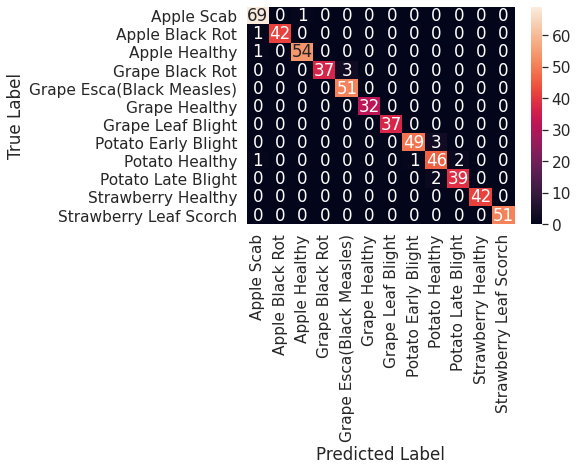

In [ ]:
# CONFUSION MATRIX
conf_matrix = confusion_matrix(np.argmax(y_test,axis=1),prediction)

print("Confusion Matrix is : ")

df = pd.DataFrame(conf_matrix,columns=['Apple Scab',
 'Apple Black Rot',
 'Apple Healthy',
 'Grape Black Rot',
 'Grape Esca(Black Measles)',
 'Grape Healthy',
 'Grape Leaf Blight',
 'Potato Early Blight',
 'Potato Healthy',
 'Potato Late Blight',
 'Strawberry Healthy',
 'Strawberry Leaf Scorch'],index = ['Apple Scab',
 'Apple Black Rot',
 'Apple Healthy',
 'Grape Black Rot',
 'Grape Esca(Black Measles)',
 'Grape Healthy',
 'Grape Leaf Blight',
 'Potato Early Blight',
 'Potato Healthy',
 'Potato Late Blight',
 'Strawberry Healthy',
 'Strawberry Leaf Scorch'] )
sn.set(font_scale=1.4)
sn.heatmap(df,annot=True,fmt='d')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
